# Intel Stock Analysis

Brandon Chan 5/1/2023

## Imports

In [158]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression 
from datetime import datetime

In [144]:
stock_data = pd.read_csv("INTC.csv")
stock_data['Date'] = pd.to_datetime(stock_data['Date'])
stock_data['Date_Ordinal'] = stock_data['Date'].apply(lambda x: x.toordinal())
stock_data

,Date,Open,High,Low,Close,Adj Close,Volume,Date_Ordinal
0,2019-05-01,51.099998,51.599998,50.740002,50.759998,44.420612,20467600,737180
1,2019-05-02,50.799999,51.330002,50.119999,50.549999,44.236843,22655400,737181
2,2019-05-03,51.080002,51.820000,50.730000,51.750000,45.286976,25656600,737182
3,2019-05-06,50.250000,51.279999,50.189999,51.220001,45.097672,26245200,737185
4,2019-05-07,50.599998,50.880001,49.930000,50.480000,44.446125,29713400,737186
...,...,...,...,...,...,...,...,...
1255,2024-04-25,34.560001,35.299999,34.500000,35.110001,35.110001,66549400,739001
1256,2024-04-26,31.780001,32.240002,30.639999,31.879999,31.879999,119742500,739002
1257,2024-04-29,31.860001,31.910000,31.070000,31.360001,31.360001,58533300,739005
1258,2024-04-30,31.040001,31.180000,30.420000,30.469999,30.469999,72166600,739006


## 5 Year Trend

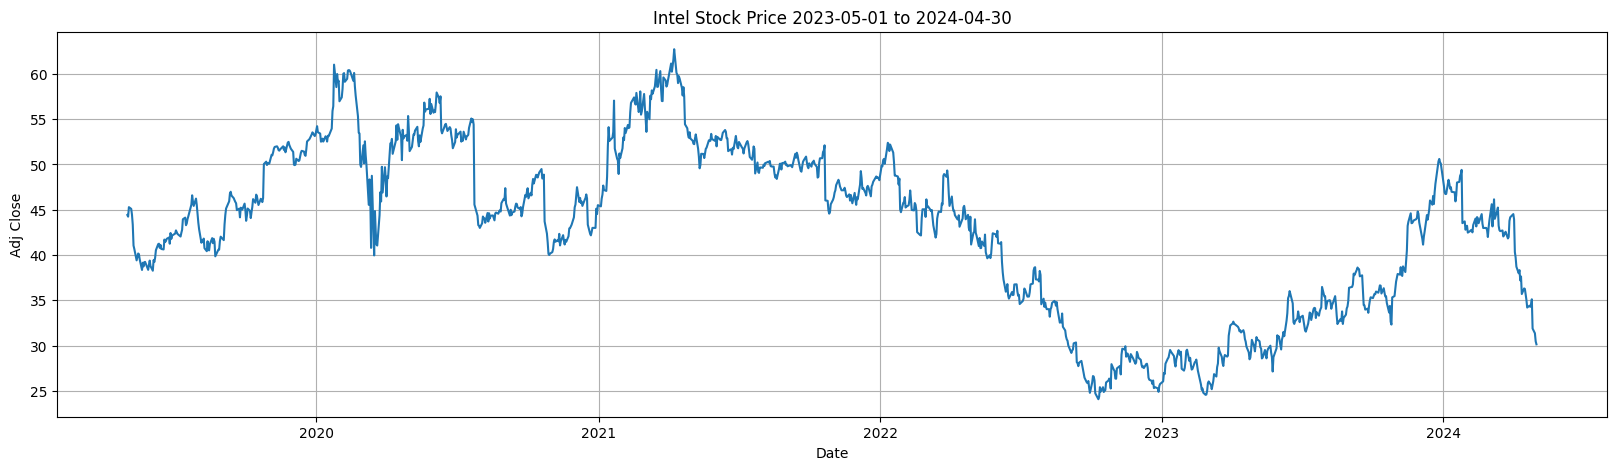

In [154]:
# Time series plot stock price 
fig, ax = plt.subplots(figsize=(20,5))
sns.lineplot(stock_data, x="Date", y="Adj Close", ax=ax)
ax.set_title("Intel Stock Price 2023-05-01 to 2024-04-30")
ax.grid()

# Higlight 
# plt.axvspan('2024-05-01'.toordinal, '2024-05-01'.toordinal, color='yellow', alpha=0.3)

plt.show()

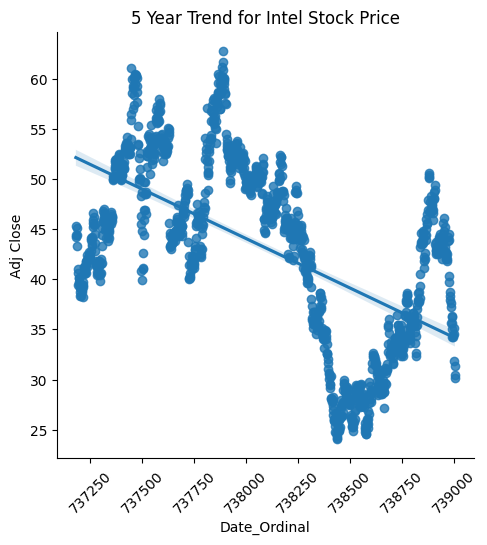

In [160]:
sns.lmplot(data=stock_data, x="Date_Ordinal", y="Adj Close")

plt.title("5 Year Trend for Intel Stock Price") 
plt.xticks(rotation=45)  
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(10))

Stock peaked in early January, currently at it's lowest point in 2024. No significant reason found for the falling price (over blown AI enthusiasm?). People think that Intel will not do well in the upcoming AI boom. Too many resources/not enough competitors (my opinion).     

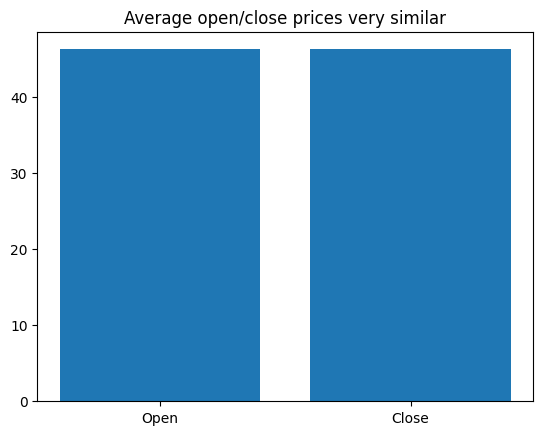

Average difference open-close -0.005299545238095504


In [162]:
# Low vs High price 

# Create lists 
x=["Open", "Close"]
y=[np.mean(stock_data.Open), np.mean(stock_data.Close)] 

# Plotting Open/Close prices 
plt.bar(x=x, height=y)
plt.title("Average open/close prices very similar") 
plt.show()

avg_diff_oc = np.mean(stock_data.Open - stock_data.Close)

print(f"Average difference open-close {avg_diff_oc}")
# So not very significant

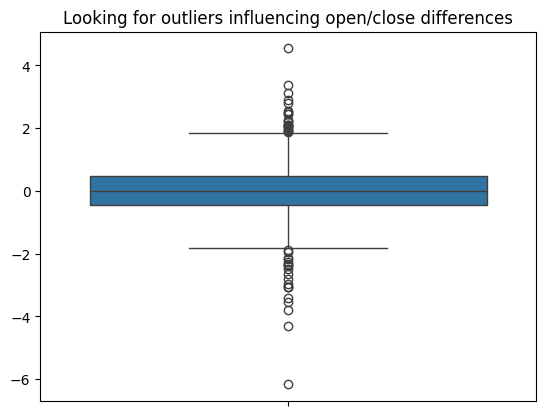

In [161]:
# Looking for outliers in price differences 
o_minus_c = stock_data.Open-stock_data.Close
sns.boxplot(o_minus_c)
plt.title("Looking for outliers influencing open/close differences")
plt.show()
# Not too severe except 3 outliers, about $2 increase/decrease 

Price tends to fall by an insignificant amount (quite a few outliers - may be unreliable). May be worth it to wait until near close, but not very likely. 

## Close vs Adjclose 
Evaluating siginificance of adjusted close price 

Average difference close-adjusted close price $3.142908892857143


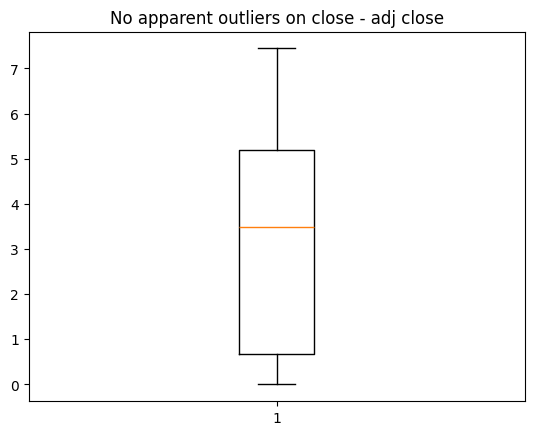

In [168]:
print(f"Average difference close-adjusted close price ${np.mean(stock_data['Close'] - stock_data['Adj Close'])}")

plt.boxplot(stock_data['Close'] - stock_data['Adj Close'])
plt.title("No apparent outliers on close - adj close")
plt.show()

So the adjusted close price seems to be about $3.14 lower on average. May be significant, should use adjusted close price. 

## Volume Time Series    

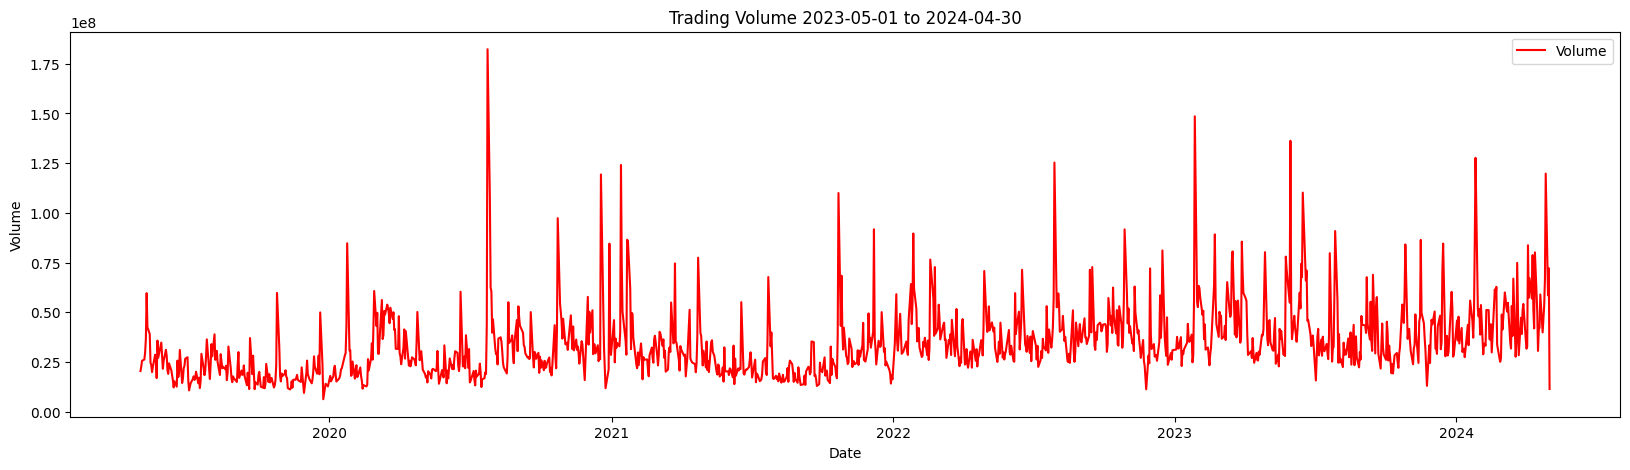

In [167]:

fig, ax=plt.subplots(figsize=(20, 5))
sns.lineplot(stock_data, x="Date", y="Volume", ax=ax, color="red", label="Volume") 
ax.set_title("Trading Volume 2023-05-01 to 2024-04-30")  
plt.show()

## Linear Regression Predictions 

In [177]:
model = LinearRegression()
model.fit(stock_data[['Date_Ordinal']], stock_data['Adj Close'])
model.predict([[datetime.now().date().toordinal()]])[0]


C:\Users\bchan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


34.15404047717129

The linear regression model predicts the stock to be up about $4 from what it is currently. Further confirms my thoughts, although using the date as the predictor seems a little iffy.